## Imports

In [72]:
import unidecode
import string
import random
import re
import time
import torch
import torch.nn as nn
import numpy as np 
import os 

from IPython.core.debugger import set_trace
from torch.autograd import Variable
from torchviz import make_dot
from torch.utils.data import TensorDataset, DataLoader
from utils import load_gfp_data, get_all_amino_acids, get_wild_type_amino_acid_sequence, count_substring_mismatch

## Model

In [2]:
# https://github.com/spro/char-rnn.pytorch/blob/master/model.py
class GenerativeRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model="lstm", n_layers=1):
        super(GenerativeRNN, self).__init__()
        self.model = model.lower()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        if self.model == "gru":
            self.rnn = nn.GRU(hidden_size, hidden_size, n_layers)
        elif self.model == "lstm":
            self.rnn = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        # input is of shape (batch_size, 1) where each input[x, 0] is the word index
        # char RNN so we generate one character at a time. 
        batch_size = input.size(0)
        encoded = self.encoder(input)
        output, hidden = self.rnn(encoded.view(1, batch_size, -1), hidden)
        output = self.decoder(output.view(batch_size, -1))
        return output, hidden
    
    def init_hidden(self, batch_size):
        if self.model == "lstm":
            return (Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)),
                    Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size)))
        return Variable(torch.zeros(self.n_layers, batch_size, self.hidden_size))
    

# Loading Data

In [3]:
all_characters = get_all_amino_acids()
num_characters = len(all_characters)
character_to_int = dict(zip(all_characters, range(num_characters)))
int_to_character = dict(zip(range(num_characters), all_characters))

In [21]:
def string_to_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for i, c in enumerate(string): 
        tensor[i] = character_to_int[c]
    return tensor

def string_to_numpy(string):
    arr = np.zeros(len(string))
    for i, c in enumerate(string): 
        arr[i] = character_to_int[c]
    return arr
    
def get_dataloader(X_train, length, n = 100, batch_size = 1, shuffle=True, random=True):
    if not random: 
        data = X_train[0:n]
    else: 
        indexes = np.random.choice(len(X_train), n)
        data = X_train[indexes]        
    dataset = np.array([string_to_numpy(x[0:length]) for x in data])
    input = torch.from_numpy(dataset[:, :-1]).long()
    output = torch.from_numpy(dataset[:, 1:]).long()
    tensor_dataset = TensorDataset(input, output)
    return DataLoader(tensor_dataset, batch_size = batch_size, shuffle = shuffle)

seq_length = 238
batch_size = 10
X_train, X_test, y_train, y_test = load_gfp_data("./data/gfp_amino_acid_")
dataloader = get_dataloader(X_train, length=seq_length, n=100, batch_size=batch_size, shuffle=True, random=True)

# Training

In [162]:
def sample(prime_str='S', predict_len=seq_length, temperature=1):
    hidden = decoder.init_hidden(1)
    prime_input = string_to_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = decoder(inp.view(1, -1), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = int_to_character[top_i.item()]
        predicted += predicted_char
        inp = string_to_tensor(predicted_char)

    return predicted


def predict(seq, prime_str="S"):
    hidden = decoder.init_hidden(1)
    prime_input = string_to_tensor(prime_str)
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    
    log_prob = 0
    for char in seq:
        output, hidden = decoder(inp.view(1, -1), hidden)
        softmax = nn.Softmax(dim = 1)
        probs = softmax(output).view(-1)
        i = character_to_int[char]
        log_prob += np.log(probs[i].item())
    return log_prob



In [161]:
def enumerate_all_sequences(string, base = "S", depth = 3): 
    if depth == 0: 
        return np.e ** predict(string, base)
    total = 0
    for c in all_characters: 
        total += enumerate_all_sequences(string + c, base, depth - 1)
    return total

for depth in range(1, 4):
    for base in "QRST":
        np.testing.assert_almost_equal(1, enumerate_all_sequences("", base, depth))

In [184]:
wild_type = get_wild_type_amino_acid_sequence()
three_mutation = "".join([int_to_character[np.random.randint(0, num_characters)] if i % 3 == 1 else wild_type[i] for i in range(10)])
ten_mutation = "".join([int_to_character[np.random.randint(0, num_characters)] for i in range(10)])
print(wild_type[0:10], three_mutation, ten_mutation)

trial_name = "rnn_med_sample"
logger = open("./logs/{0}.txt".format(trial_name), "w")
if not os.path.isdir("./models/{0}".format(trial_name)):
    os.mkdir("./models/{0}".format(trial_name))
    
n_epochs = 10
hidden_size = 200
n_layers = 2
lr = 0.01

decoder = GenerativeRNN(num_characters, hidden_size, num_characters, "lstm", n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
all_losses = []

for epoch in range(1, n_epochs + 1):
    total_loss = []
    for i, (input, target) in enumerate(dataloader):
        hidden = decoder.init_hidden(batch_size)
        loss = 0
        for c in range(seq_length - 1):
            output, hidden = decoder(input[:, c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:, c])
        loss.backward()
        decoder_optimizer.step()
        decoder.zero_grad()
        total_loss.append(loss.data[0] / (seq_length - 1))
    all_losses.append(np.mean(total_loss))
    generated_sequence = sample("S", seq_length)
    mismatches = count_substring_mismatch(wild_type, generated_sequence)
    wild_prob, three_mutations_prob, ten_mutations_prob = np.e ** predict(wild_type[1:10]), np.e ** predict(three_mutation[1:10]), np.e ** predict(ten_mutation[1:10])
    print("epoch {0}. loss: {1:.2f}. time: {2:.2f} seconds.".format(epoch, all_losses[-1], time.time() - start_time), file = logger)
    print("generated sequence: {0}\n{1} mismatches from the wild type".format(generated_sequence, mismatches), file = logger) 
    print("wild type probability: {0}. 3 mutations probability: {1}. 10 mutations probability: {2}.\n" \
          .format(wild_prob, three_mutations_prob, ten_mutations_prob), file = logger)
    torch.save({
                'epoch': epoch,
                'model_state_dict': decoder.state_dict(),
                'optimizer_state_dict': decoder_optimizer.state_dict(),
                'loss': np.mean(total_loss)
            }, "./models/{0}/checkpoint_{1}.pt".format(trial_name, epoch))
logger.close()

SKGEELFTGV SEGEKLFDGV GADKAM*HFM


/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


# Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

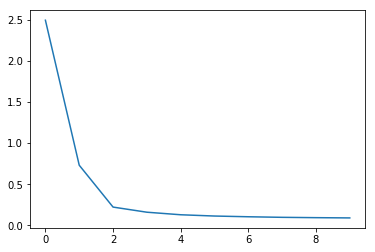

In [8]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

In [163]:
generated_sequence = sample("S", seq_length, 0.8)
print("generated sequence: {0} with {1} mismatches from the wild type".format(generated_sequence, 
                                                                                 count_substring_mismatch(wild_type, generated_sequence)))      

generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNHKTRAEVKFEGGTLVNRIELKGIDFKEDGNIQGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK** with 4 mismatches from the wild type


In [164]:
generated_sequence = sample("S", seq_length, 0.1)
print("generated sequence: {0} with {1} mismatches from the wild type".format(generated_sequence, 
                                                                                 count_substring_mismatch(wild_type, generated_sequence)))      

generated sequence: SKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTLSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK** with 1 mismatches from the wild type


In [165]:
generated_sequence = sample("S", seq_length, 1.4)
print("generated sequence: {0} with {1} mismatches from the wild type".format(generated_sequence, 
                                                                                 count_substring_mismatch(wild_type, generated_sequence)))

generated sequence: SKGEELFTGVVPILVPDFGKTLKNIGLKGILEFTTGAGKLVPWPTLVTTLSYGVQCLSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYQDYNDHNVFVNILDHKQNIGGVKLELDGHNVYIMADKQKNGIKVNFKIRHNIEDGDVNRITLK*KDIEGNHMLKGIDFKEDGNILGHWLEYNYSYNVYIMAREQSHDGVQ with 209 mismatches from the wild type


In [60]:
wild_type = get_wild_type_amino_acid_sequence()
n_epochs = 10
hidden_size = 100
n_layers = 1
lr = 0.005

trial_name = "rnn_small_sample"
logger = open("./logs/{0}.txt".format(trial_name), "a")
if not os.path.isdir("./models/{0}".format(trial_name)):
    os.mkdir("./models/{0}".format(trial_name))
    
decoder = GenerativeRNN(num_characters, hidden_size, num_characters, "lstm", n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
start_time = time.time()
all_losses = []

for epoch in range(1, n_epochs + 1):
    total_loss = []
    for i, (input, target) in enumerate(dataloader):
        hidden = decoder.init_hidden(batch_size)
        loss = 0
        for c in range(seq_length - 1):
            output, hidden = decoder(input[:, c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:, c])
        loss.backward()
        decoder_optimizer.step()
        decoder.zero_grad()
        total_loss.append(loss.data[0] / (seq_length - 1))
    print(total_loss, file=logger)
    all_losses.append(np.mean(total_loss))
    print("epoch {0}. loss: {1:.2f}. time: {2:.2f} seconds.".format(epoch, all_losses[-1], time.time() - start_time), file=logger)
    generated_sequence = sample("S", seq_length)
    print("generated sequence: {0}\n{1} mismatches from the wild type".format(generated_sequence, 
                                                                        count_substring_mismatch(wild_type, generated_sequence)), file=logger)
    torch.save({
            'epoch': epoch,
            'model_state_dict': decoder.state_dict(),
            'optimizer_state_dict': decoder_optimizer.state_dict(),
            'loss': np.mean(total_loss)
        }, "./models/{0}/checkpoint_{1}.pt".format(trial_name, epoch))
    
logger.close()

/Users/chuck/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:29: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


In [30]:
"""
1. print to file the epoch the time it took and the loss, print out a generated sample and the mismatches (DONE)
2. plot history (DONE)
3. save model every epoch, load model at end, plot model architecture (DONE)
4. tensorboard going (DONE)
5. code it into class (DONE)
6. DEBUG 10 (DONE)
7. Write tests 10 min 
"""

In [70]:
def load_model(trial_name, epoch):
    checkpoint = torch.load("./models/{0}/checkpoint_{1}.pt".format(trial_name, epoch))
    decoder = GenerativeRNN(num_characters, hidden_size, num_characters, "lstm", n_layers)
    decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
    decoder.load_state_dict(checkpoint["model_state_dict"])
    decoder_optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    return decoder, decoder_optimizer

decoder, decoder_optimizer = load_model(trial_name, 5)

GenerativeRNN(
  (encoder): Embedding(21, 100)
  (rnn): LSTM(100, 100)
  (decoder): Linear(in_features=100, out_features=21, bias=True)
)

In [108]:
def plot_model(save_dir, verbose=True):
    hidden = decoder.init_hidden(1)
    out, _ = decoder(string_to_tensor("S"), hidden)
    graph = make_dot(out)
    if save_dir is not None:
        graph.format = "png"
        graph.render(save_dir) 
    if verbose:
        graph.view()
        
plot_model("./logs/{0}".format(trial_name))


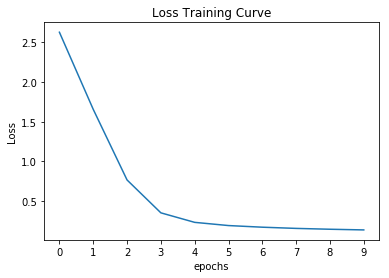

In [29]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.title("Loss Training Curve")
plt.plot(all_losses)
plt.xlabel("epochs")
plt.ylabel("Loss")
plt.xticks(range(10))
plt.show()